# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()

X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

In [69]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

X_train_bin.shape, y_train_bin.shape

((1064, 15566), (1064,))

In [70]:

class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0.0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def logistic_loss(self, y_hat, y, x):
        loss = -y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)
        return loss.sum() / x.shape[0] + (self.llambda / 2) * self.w.T.dot(self.w)
    
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0.0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
                # forward pass
                # <TODO> [1 point] calculate batch loss
                A = self.predict_proba(batch_X)
                loss = self.logistic_loss(A, batch_y, batch_X)

                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                grad_w = (1 / batch_X.shape[0]) * batch_X.T.dot(A - batch_y) + self.llambda * self.w
                grad_b = (1 / batch_X.shape[0]) * np.sum(A - batch_y)

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        Z = X.dot(self.w) + self.b
        A = self.sigmoid(Z)
        return A
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda = 0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)

auc 0.9970989032242468


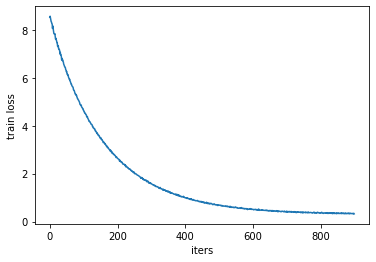

In [71]:
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin.toarray())))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [0]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = x @ self.W + self.b
        return result

In [0]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [0]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        
        best = np.min(np.array(history['valid']))
        if all(map(lambda x: x > best, history['valid'][-5:])):
          print('Early stopping')
          break

    return history 

### predict hard labels [1 point]

In [0]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = torch.argmax(model(batch_x), -1)
            result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [77]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



train loss: 3.297 valid loss:3.097



train loss: 2.858 valid loss:2.736



train loss: 2.503 valid loss:2.452



train loss: 2.217 valid loss:2.210



train loss: 1.982 valid loss:2.023



train loss: 1.792 valid loss:1.862



train loss: 1.639 valid loss:1.748



train loss: 1.508 valid loss:1.627



train loss: 1.403 valid loss:1.546



train loss: 1.314 valid loss:1.470



train loss: 1.237 valid loss:1.414



train loss: 1.177 valid loss:1.359



train loss: 1.121 valid loss:1.323



train loss: 1.076 valid loss:1.269



train loss: 1.036 valid loss:1.236



train loss: 0.996 valid loss:1.200



train loss: 0.966 valid loss:1.178



train loss: 0.938 valid loss:1.151



train loss: 0.912 valid loss:1.130



train loss: 0.891 valid loss:1.117



train loss: 0.872 valid loss:1.101



train loss: 0.855 valid loss:1.086



train loss: 0.836 valid loss:1.066



train loss: 0.827 valid loss:1.059



train loss: 0.812 valid loss:1.051



train loss: 0.799 valid loss:1.038



train loss: 0.791 valid loss:1.032



train loss: 0.780 valid loss:1.026



train loss: 0.775 valid loss:1.022



train loss: 0.766 valid loss:1.013



train loss: 0.761 valid loss:1.007



train loss: 0.753 valid loss:1.009



train loss: 0.746 valid loss:0.994



train loss: 0.742 valid loss:1.003



train loss: 0.737 valid loss:0.990



train loss: 0.732 valid loss:0.984



train loss: 0.727 valid loss:0.982



train loss: 0.725 valid loss:0.983



train loss: 0.721 valid loss:0.979



train loss: 0.718 valid loss:0.971



train loss: 0.714 valid loss:0.970



train loss: 0.712 valid loss:0.969



train loss: 0.709 valid loss:0.964



train loss: 0.708 valid loss:0.967



train loss: 0.704 valid loss:0.970



train loss: 0.703 valid loss:0.963



train loss: 0.702 valid loss:0.968



train loss: 0.702 valid loss:0.968



train loss: 0.699 valid loss:0.961



train loss: 0.694 valid loss:0.958



train loss: 0.695 valid loss:0.956



train loss: 0.693 valid loss:0.955



train loss: 0.692 valid loss:0.955



train loss: 0.692 valid loss:0.958



train loss: 0.692 valid loss:0.953



train loss: 0.690 valid loss:0.964



train loss: 0.691 valid loss:0.956



train loss: 0.688 valid loss:0.954



train loss: 0.688 valid loss:0.951



train loss: 0.686 valid loss:0.956



train loss: 0.686 valid loss:0.951



train loss: 0.685 valid loss:0.951



train loss: 0.684 valid loss:0.947



train loss: 0.684 valid loss:0.950



train loss: 0.684 valid loss:0.951



train loss: 0.682 valid loss:0.944



train loss: 0.682 valid loss:0.950



train loss: 0.680 valid loss:0.951



train loss: 0.682 valid loss:0.954



train loss: 0.681 valid loss:0.952



train loss: 0.680 valid loss:0.948
Early stopping


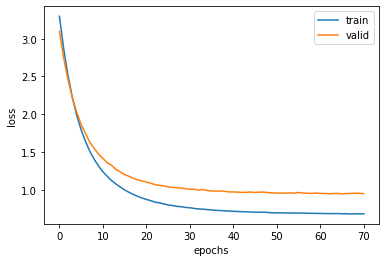

In [78]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [79]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

0.8094795539033457

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [0]:
from sklearn.dummy import DummyClassifier

In [81]:
Dum_cl = DummyClassifier(strategy='uniform')
Dum_cl.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='uniform')

In [0]:
y_pred = Dum_cl.predict_proba(X_test)

In [83]:
metrics.log_loss(y_test, y_pred)

2.9957322735539913

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

In [84]:
y_pred = [0] * y_test.shape[0]
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.042352628783855546